In [1]:
from pathlib import Path

# setup the data files and modules
fname = Path('puck.wav')
if not fname.exists():
    !wget -q 'nikolaaksonen.fi/puck.wav'
!mkdir -p 'modules'
!wget -q -O 'modules/segment.py' 'https://raw.githubusercontent.com/solita/ivves-machine-spraak/main/modules/segment.py'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import modules.segment as sgt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=UserWarning)

# TUNI 25.4.2022 - Toy example: how to detect a puck hitting a goal post

In this notebook we want to see how to detect a puck hitting a goal post in the middle of a hockey game.
Here we demonstrate how to use "lower level" libraries like `scipy` and `numpy` to perform the analysis.
In practice you might be better off relying on dedicated audio analysis libraries like `librosa`, which
would turn many of the things done here into oneliners.

## Loading up the data

To get the audio data into Python we use the `scipy` library's `wavfile.read()` function. Our input audio file is a stereo recording so we separate the channels into their own arrays. Another option could be to take for example the mean of the two channels, but one has to be careful with this in case the waves cancels each other out.

In [3]:
from scipy.io import wavfile

sr, puck_wav = wavfile.read(fname)
print(f'Sample rate is {sr} Hz.')
puck_L = puck_wav[:, 0]
puck_R = puck_wav[:, 1]

Sample rate is 48000 Hz.


Let's first look at the waveforms for both channels.

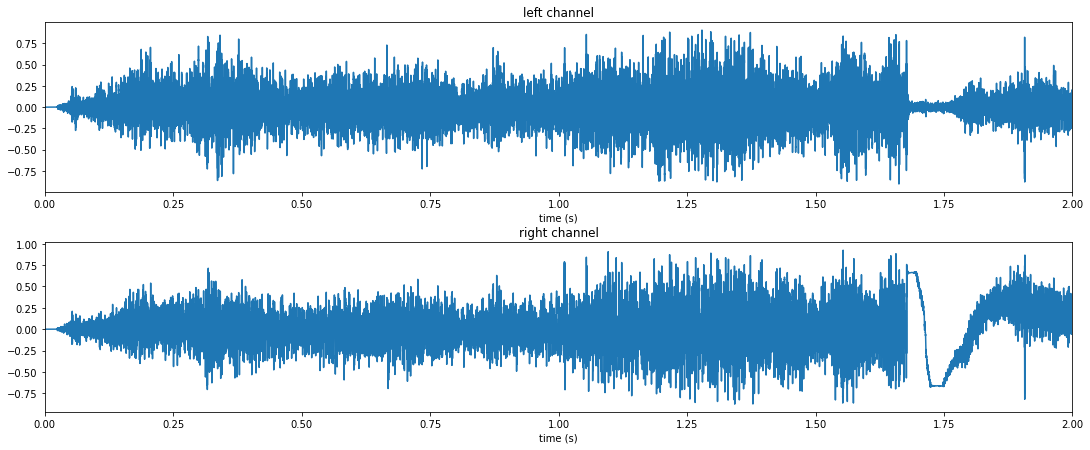

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
xx = np.linspace(0, len(puck_L) // sr, num=len(puck_L))
ax1.plot(xx, puck_L)
ax1.set_title('left channel')
ax2.plot(xx, puck_R)
ax2.set_title('right channel')
for ax in [ax1, ax2]:
    ax.set_xmargin(0)
    ax.set_xlabel('time (s)')
plt.show()

There's something strange happening with the right channel at around 1.7 seconds, so let's stick to the left channel for now (although you check that the analysis we'll do below works perfectly well for the right channel, too).

In Jupyter notebooks we can use `Ipython.display.Audio()` to play numpy arrays as audio. Very useful for audio analysis, because you can apply some processing techniques and easily hear how it affects the result!

In [5]:
from IPython.display import Audio

Audio(puck_L, rate=sr)

In [6]:
Audio(puck_R, rate=sr)

## Spectrogram

Now let's start the spectral analysis. The subpackages `scipy.signal` provides many useful tools for signal processing.
We'll first set up our Fourier transform parameters and then compute the spectrogram. For our FFT-window we use a Tukey window, you can check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html) for a list of other available window types.

In [7]:
from scipy import signal

nperseg = 512
noverlap = nperseg // 2
fft_params = {'window': signal.get_window(('tukey', 0.25), nperseg),
              'nperseg': nperseg,
              'noverlap': noverlap,
              'nfft': nperseg,
              'mode': 'magnitude',
              'detrend': 'constant'}
# change puck_L to puck_R to experiment with the right channel
fs, ts, Sxx = signal.spectrogram(puck_L, sr, **fft_params)

Let's now use `matplotlib` to visualise the spectrogram. Note that to get a meaningful set of values
we normalise and scale the Fourier coefficients to a dB scale (in our normalisation +0 dB corresponds to the loudest level).

/var/folders/jb/3smwxhqs6x19hclczq9prsw80000gq/T/ipykernel_79983/3451035676.py:2: RuntimeWarning: divide by zero encountered in log10
  p = ax.pcolormesh(ts, fs, 10*np.log10(Sxx / np.max(Sxx)), shading='auto', cmap='magma')


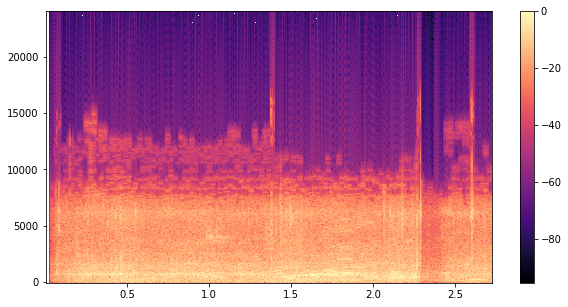

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
p = ax.pcolormesh(ts, fs, 10*np.log10(Sxx / np.max(Sxx)), shading='auto', cmap='magma')
fig.colorbar(p)
plt.show()

This doesn't look so good and we're also getting some division by zero (visible as white dots in the above graph)! This happens because we're trying to take logarithms of a very small number and the computer is rounding this down to zero. On the left we can also see a white strip which corresponds to a part where our input signal is just zero to begin with.

To overcome this problem we replace these small values by some fixed lower bound, epsilon.

In [9]:
eps = 1e-5
Sxx = np.clip(Sxx, eps, None)

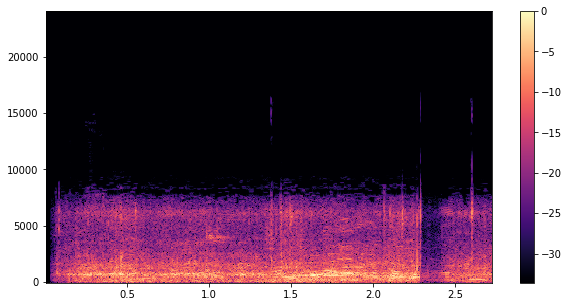

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
p = ax.pcolormesh(ts, fs, 10*np.log10(Sxx / np.max(Sxx)), shading='auto', cmap='magma')
fig.colorbar(p)
plt.show()

Now, see if you can spot the part of the spectrogram where the puck hitting the goal post is visible. It occurs at around 1 second from the beginning.

How could we try to detect this? The most naive solution might be to isolate this frequency band and simply check for the mean magnitude. By eyballing it, let's say that this sound lies somewhere between 3.5 and 4 kHz (blue lines below).

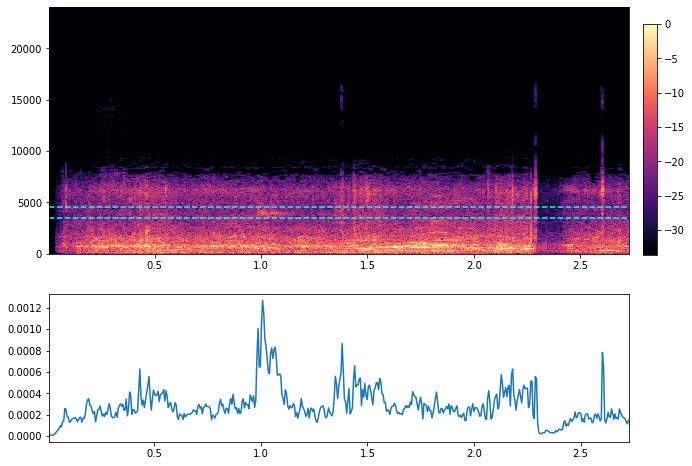

In [11]:
lb, ub = 3500, 4500
# Find the index of the frequencies which fall between 3.5 and 4.5 kHz
idx = np.argwhere((fs > lb) & (fs < ub)).ravel()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), gridspec_kw={'height_ratios': [5, 3]})
p = ax1.pcolormesh(ts, fs, 10*np.log10(Sxx / np.max(Sxx)), shading='auto', cmap='magma')
ax1.axhline(lb, color='cyan', ls='--')
ax1.axhline(ub, color='cyan', ls='--')
ax2.plot(ts, np.mean(Sxx[idx, :], axis=0))
ax2.set_xmargin(0)
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.95, 0.45, 0.02, 0.4])
fig.colorbar(p, cax=cax)
plt.show()

Above we see that the curve has a wide peak around the event as we'd hope. This is not very robust though (check what happens with the right channel, for instance), but we can alleviate things a bit by normalising properly. We add a smoothing factor `gamma` to account for silent moments in the signal. You can try out what happens with the right channel when you adjust `gamma`.

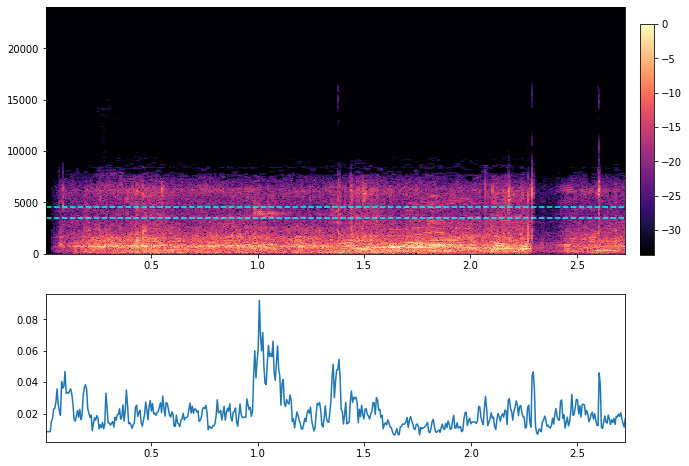

In [12]:
gamma = 0.001
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), gridspec_kw={'height_ratios': [5, 3]})
p = ax1.pcolormesh(ts, fs, 10*np.log10(Sxx / np.max(Sxx)), shading='auto', cmap='magma')
ax1.axhline(lb, color='cyan', ls='--')
ax1.axhline(ub, color='cyan', ls='--')
ax2.plot(ts, np.mean(Sxx[idx, :] / (np.linalg.norm(Sxx, axis=0, ord=2)+gamma), axis=0))
ax2.set_xmargin(0)
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.95, 0.45, 0.02, 0.4])
fig.colorbar(p, cax=cax)
plt.show()

For the left channel this method seems to work ok, but you can see how it fails on the right channel to some extent.
Nevertheless, let's explore our signal a bit more.

## Self-similarity

We first plot the self-similarity matrix (SSM) for our clip below. You can check the definition and details of the SSM from the slides. To obtain the SSM we combine two `scipy` functions `pdist()` and `squareform()`, which compute the pairwise distances and expresses these as a symmetric matrix, respectively.

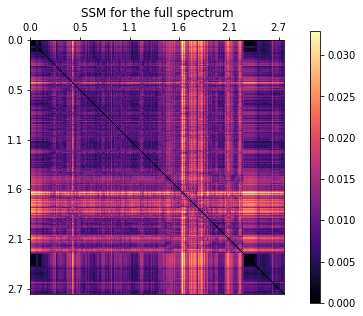

In [13]:
from scipy.spatial.distance import pdist, squareform

S = squareform(pdist((Sxx).T, metric='euclidean'))

fig, (ax, cax), = plt.subplots(ncols=2, figsize=(5.2, 5), gridspec_kw={'width_ratios': [5, 0.2]})
p = ax.imshow(S, cmap='magma', interpolation='nearest', aspect='equal')
xt = [ts[-1] * i / Sxx.shape[1] for i in ax.get_xticks()]
ax.set_xticklabels([f'{x:.1f}' for x in xt])
ax.set_yticklabels([f'{x:.1f}' for x in xt])
ax.xaxis.set_ticks_position('top')
ax.set_title('SSM for the full spectrum')
fig.colorbar(p, cax=cax)
plt.show()

Although it looks pretty, this doesn't seem so useful as the loud background noise dominates.
Let's now combine this with our idea of filtering a specific frequency band.

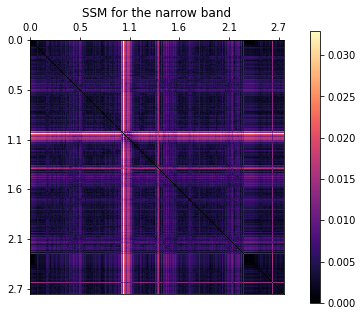

In [14]:
# We use the idx mask to pick out our desired frequency band
S = squareform(pdist((Sxx[idx, :]).T, metric='euclidean'))

fig, (ax, cax), = plt.subplots(ncols=2, figsize=(5.2, 5), gridspec_kw={'width_ratios': [5, 0.2]})
ax.imshow(S, cmap='magma', interpolation='nearest', aspect='equal')
xt = [ts[-1] * i / Sxx.shape[1] for i in ax.get_xticks()]
ax.set_xticklabels([f'{x:.1f}' for x in xt])
ax.set_yticklabels([f'{x:.1f}' for x in xt])
ax.xaxis.set_ticks_position('top')
ax.set_title('SSM for the narrow band')
fig.colorbar(p, cax=cax)
plt.show()

Now we're rolling! Our event (which starts at about 1 s) is clearly visible in the plot along with some smaller noise. Try to check what happens here with the right channel.

To convert this pretty plot into a feature we do what we talked about in the lecture and construct a suitable kernel which we convolve with the main diagonal. The simplest choice is the checkerboard kernel.

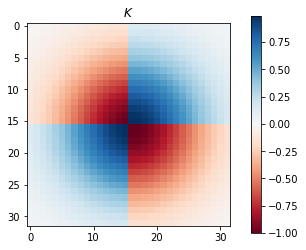

In [15]:
K = sgt.kernel(32, smoothing='gaussian', strength=4)

fig, (ax, cax), = plt.subplots(ncols=2, figsize=(4.2, 4), gridspec_kw={'width_ratios': [4, 0.2]})
p = ax.imshow(K, cmap='RdBu')
fig.colorbar(p, cax=cax)
ax.set_title('$K$')
plt.show()

We slide $K$ along the diagonal to obtain the *novelty score*, which shows the level of kernel activation.

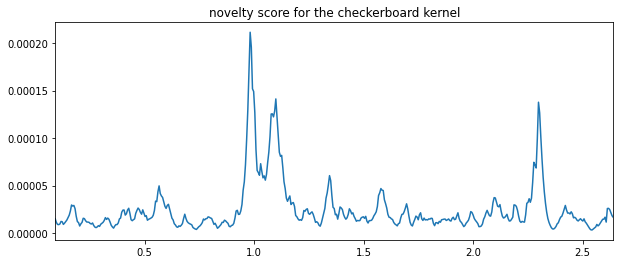

In [16]:
nov = sgt.novelty_fast(S, K)
fig, ax = plt.subplots(figsize=(10, 4))
# since the kernel is centered, we need to adjust the x-axis
# for accurate time stamps
ax.plot(ts[len(K)//2:-len(K)//2], nov)
ax.set_xmargin(0)
ax.set_title('novelty score for the checkerboard kernel')
plt.show()

This seems pretty good and the kernel clearly activates when our event occurs (in fact it picks out the *boundaries* of the event, as that's what the checkerboard kernel is designed to do), but we see that there are some undesired activations around 2.3 s. We can improve this by designing a different kernel which better matches what we're trying to predict.
The checkerboard kernel is obtained by scaling up the kernel primitive

$$K_{prim}=\begin{pmatrix} -1 & 1\\ 1 & -1\end{pmatrix}.$$

Let's try to use a cross shaped primitive instead:

$$K_{prim}=\begin{pmatrix} -1 & 1 & -1\\ 1 & 1 & 1\\ -1 & 1 & -1\end{pmatrix}.$$

With this choice of $K_{prim}$ we obtain the kernel shown below:

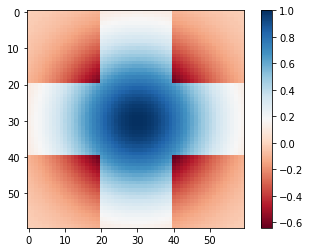

In [17]:
K_prim = np.array([[-1, 1, -1],
                    [1,  1,  1],
                    [-1, 1, -1]])
K = sgt.kernel(3*20, smoothing='gaussian', strength=4, kernel_primitive=K_prim)
plt.imshow(K, cmap='RdBu')
plt.colorbar()
plt.show()

We can plot this over the SSM to see how it matches with the event.

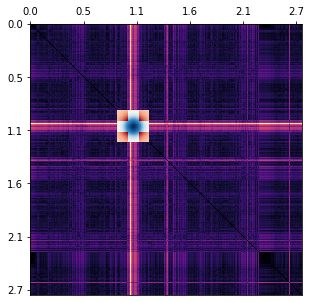

In [18]:
from scipy.spatial.distance import pdist, squareform
fig, ax = plt.subplots(figsize=(5, 5))
start = 164
S_masked = S.copy()
slc = slice(start, start + len(K))
S_masked[slc, slc] = None
K_masked = np.full_like(S_masked, None)
K_masked[slc, slc] = K
ax.imshow(S_masked, cmap='magma', interpolation='nearest')
ax.imshow(K_masked, cmap='RdBu', interpolation='nearest')
xt = [ts[-1] * i / Sxx.shape[1] for i in ax.get_xticks()]
ax.set_xticklabels([f'{x:.1f}' for x in xt])
ax.set_yticklabels([f'{x:.1f}' for x in xt])
ax.xaxis.set_ticks_position('top')
plt.show()

And finally we compute the novelty score for this new $K$:

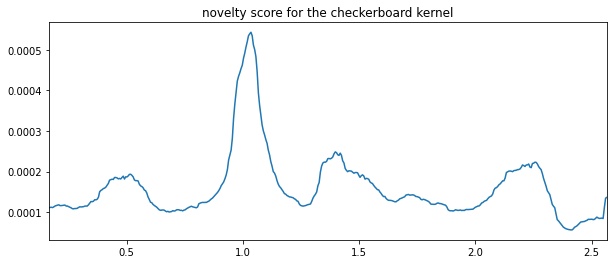

In [19]:
nov = sgt.novelty_fast(S, K)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts[len(K)//2:-len(K)//2], nov)
ax.set_xmargin(0)
ax.set_title('novelty score for the checkerboard kernel')
plt.show()

And there we go! This seems to react much better solely to our event of interest, but of course this method is still fairly primitive. The next step would be to collect some more sounds of a puck hitting a goal post and to investigate how our method might fail and to figure out how to overcome these obstacles.